In [15]:
import pandas as pd # dataframes and csv
import numpy as np # linear algebra
import sklearn as sk # data maniputation
import matplotlib.pyplot as plt # data visualization
import re # regular expressions for the text
import tensorflow as tf # for ML


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer
from tokenizers import SentencePieceBPETokenizer
#from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab



                                                  text sentiment
0    Hi Leah, I ordered this early to give to a co-...  Positive
1    Good evening, \n  I just received my order! I ...  Positive
2    I couldn’t find where I could write a review b...  Positive
3    I received my order today and gave it to my si...  Positive
4    ﻿Max,\n\nWe received the heart but sadly are d...  Negative
..                                                 ...       ...
249    Thank you, this is beautiful and they loved it.  Positive
250                    Thanks so much. They lookgreat!  Positive
251  Emily, \n  THANK YOU so much for the new “bric...  Positive
252  Jacqueline,  \n  I just received the replaceme...  Positive
253  Order #(857)982-509708\nI just received my ord...  Positive

[254 rows x 2 columns]


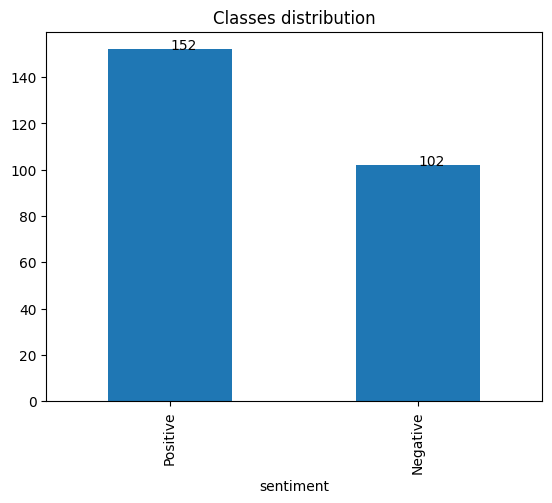

In [6]:
labels = pd.read_csv("./data/labels.csv")
reviews = pd.read_csv("./data/reviews.csv")

reviews = reviews.merge(labels,"outer","id")
dataset = reviews.drop(labels = "id",axis=1)
print(dataset)



dataset["sentiment"].value_counts().plot(kind='bar', title='Classes distribution')
count_positive = len([i for i in dataset["sentiment"] if i=="Positive"])
count_negative = len([i for i in dataset["sentiment"] if i=="Negative"])
plt.text(0,count_positive,str(count_positive))
plt.text(1,count_negative,str(count_negative))
plt.show()


Negative to Positive ratio is okay. No need to fix training and testing datasets manualy

In [55]:
#Finding the vocab size
words = []
delimiters = [",", ")", "("]
max_length = []

for i in dataset["text"]:
    i = re.split(r'[,\s!?()._\-]+', i)
    i = [j for j in i if j is not None and j!=""]
    max_length.append(len(i))
    for j in i:

        words.append(j)
words = list(set(words))
print(max(max_length))
print(len(words))
print("AVG LENGTH: " + str(np.array([len(i) for i in dataset["text"]]).mean()))

266
2488
AVG LENGTH: 303.0


In [8]:
train, test = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for t in train["text"]:
  training_sentences.append(t)

for s in train["sentiment"]:
  if s == "Positive": # Redo the labels so the processing is faster 
    training_labels.append(1)
  else:
    training_labels.append(0)

# Loop over all test examples and save the sentences and labels
for t in test["text"]:
  testing_sentences.append(t)

for s in test["sentiment"]:
  if s == "Positive": # Redo the labels so the processing is faster 
    testing_labels.append(1)
  else:
    testing_labels.append(0)

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)



Tokenizing subwords

In [120]:
with open("text.txt", "w", encoding="utf-8") as f:
    for sentence in dataset["text"]:
        f.write(sentence+"\n")
    f.close()

BPE_sentence_tokenizer = SentencePieceBPETokenizer()
BPE_sentence_tokenizer.train("text.txt",vocab_size=1000)
encoded_texts = [BPE_sentence_tokenizer.encode(text).ids for text in dataset["text"]]
# Pad the sequences to a consistent length
max_sequence_length = 50  # Adjust this based on your dataset
X = pad_sequences(encoded_texts, maxlen=max_sequence_length, padding='pre')
label_mapping = {"Positive": 1, "Negative": 0}
encoded_labels = [label_mapping[label] for label in dataset["sentiment"]]
y = np.array(encoded_labels)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(y_val))

51


Tokenizing words

In [121]:
# Parameters
vocab_size = 1000
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(f'number of words in word_index: {len(word_index)}')


# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences)
print(training_labels_final)

number of words in word_index: 1755
[1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0
 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1
 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0]


In [122]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [151]:
# Parameters
embedding_dim = 8
lstm_dim = 16
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dropout(.7),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.007)

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 8)           8000      
                                                                 
 bidirectional_17 (Bidirect  (None, 32)                3200      
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_34 (Dense)            (None, 6)                 198       
                                                                 
 dense_35 (Dense)            (None, 1)                 7         
                                                                 
Total params: 11405 (44.55 KB)
Trainable params: 11405 (44.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [152]:
NUM_EPOCHS = 12
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val, y_val))

Epoch 1/12
2/2 [==============================] - 5s 909ms/step - loss: 0.6940 - accuracy: 0.4877 - val_loss: 0.6905 - val_accuracy: 0.6863
Epoch 2/12
2/2 [==============================] - 0s 72ms/step - loss: 0.6909 - accuracy: 0.5714 - val_loss: 0.6836 - val_accuracy: 0.6863
Epoch 3/12
2/2 [==============================] - 0s 105ms/step - loss: 0.6845 - accuracy: 0.5813 - val_loss: 0.6702 - val_accuracy: 0.6863
Epoch 4/12
2/2 [==============================] - 0s 64ms/step - loss: 0.6801 - accuracy: 0.5764 - val_loss: 0.6542 - val_accuracy: 0.6863
Epoch 5/12
2/2 [==============================] - 0s 73ms/step - loss: 0.6723 - accuracy: 0.5764 - val_loss: 0.6380 - val_accuracy: 0.6863
Epoch 6/12
2/2 [==============================] - 0s 80ms/step - loss: 0.6694 - accuracy: 0.5764 - val_loss: 0.6214 - val_accuracy: 0.6863
Epoch 7/12
2/2 [==============================] - 0s 80ms/step - loss: 0.6543 - accuracy: 0.5862 - val_loss: 0.6042 - val_accuracy: 0.6863
Epoch 8/12
2/2 [=========

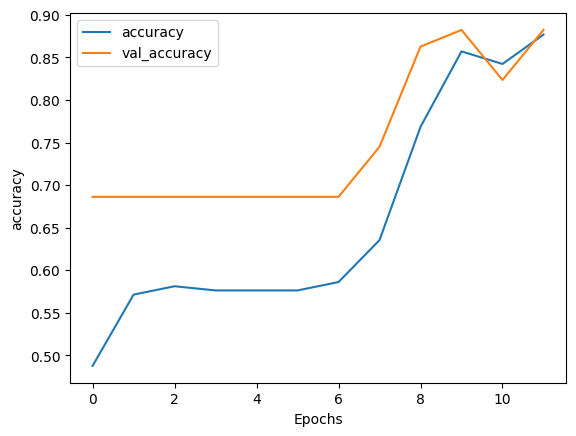

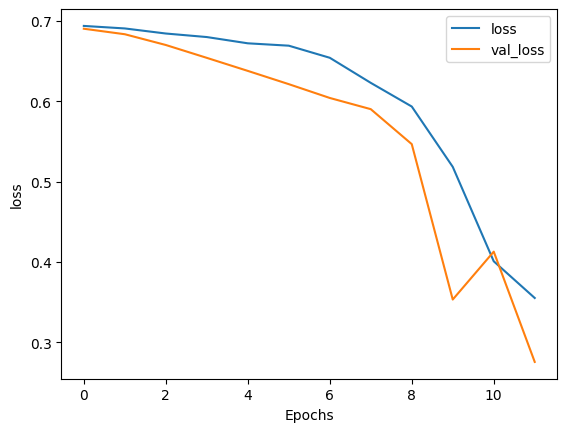

In [153]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [154]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model_lstm.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

# Get the index-word dictionary
reverse_word_index = tokenizer.index_word


(1000, 8)


In [155]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [168]:
seed_text = "I just received my order!  They are fantastic - even better than I expected.   I ordered 3 different items but only received 1 cleaning cloth.  Can you send me 2 more?  Thank you.  James Young"
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], padding='pre')
# Feed to the model and get the probabilities for each index
probabilities = model_lstm.predict(token_list, verbose=0)
# Get the index with the highest probability
predicted = np.argmax(probabilities, axis=-2)
print(probabilities)
if probabilities[0][0]>0.5:
    print("1")
else:
    print("0")

[[0.2870656]]
0
